In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

grid_roads = pd.read_pickle('data/grid_roads.pkl').reset_index(drop=True)
selected_GU = ['강남구']
selected_GU = ['서울특별시 ' + gu for gu in selected_GU]

seoul = gpd.read_file('data/seoul_geo/seoul.shp').to_crs(epsg=5174)
seoul_selected = seoul[seoul.SGG_NM.isin(selected_GU)]
roads_selected = gpd.sjoin(grid_roads, seoul_selected, op='intersects')
roads_selected = roads_selected.reset_index(drop=True)

roads_selected.drop(columns=['index_right'], inplace=True)

link = pd.read_excel('data/traffic/link.xlsx')
link = gpd.GeoDataFrame(link, geometry=gpd.points_from_xy(link['GRS80TM_X'], link['GRS80TM_Y']), crs='epsg:5174')

from shapely.geometry import LineString

link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()
link_line.columns = ['LINK_ID', 'geometry']
link_line = gpd.GeoDataFrame(link_line, crs='epsg:5174')

/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_87666/1033422442.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  link_line = link.groupby('LINK_ID').apply(lambda x: LineString(x['geometry'].tolist())).reset_index()


In [71]:
roads = gpd.read_file('data/seoul_road/Z_KAIS_TL_SPRD_MANAGE_11.shp', encoding='euc-kr', crs='epsg:5179')
roads = roads.to_crs('epsg:5174')
roads = roads[roads.ROA_CLS_SE.isin(['1','2','3'])]

In [75]:
roads_selected = gpd.sjoin(roads, seoul_selected, op='intersects').drop(columns=['index_right'])

/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [78]:
roads_selected = gpd.sjoin(roads_selected, grid_roads, op='intersects')

/Users/dangchan/miniforge3/envs/colab/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [82]:
roads_selected.geometry

162      LINESTRING (198294.379 441597.465, 198307.807 ...
162      LINESTRING (198294.379 441597.465, 198307.807 ...
162      LINESTRING (198294.379 441597.465, 198307.807 ...
162      LINESTRING (198294.379 441597.465, 198307.807 ...
162      LINESTRING (198294.379 441597.465, 198307.807 ...
                               ...                        
66917    LINESTRING (206660.483 437778.063, 206660.453 ...
66917    LINESTRING (206660.483 437778.063, 206660.453 ...
66917    LINESTRING (206660.483 437778.063, 206660.453 ...
66917    LINESTRING (206660.483 437778.063, 206660.453 ...
66917    LINESTRING (206660.483 437778.063, 206660.453 ...
Name: geometry, Length: 713, dtype: geometry

In [83]:
# roads to network for intersecting with grid

import momepy

network = momepy.gdf_to_nx(roads_selected.explode(), approach='primal')

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_87666/88434891.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  network = momepy.gdf_to_nx(roads_selected.explode(), approach='primal')


In [84]:
nx.floyd_warshall_numpy(network, weight='mm_len')

array([[   0.        , 5639.97575429,           inf, ...,           inf,
                  inf,           inf],
       [5639.97575429,    0.        ,           inf, ...,           inf,
                  inf,           inf],
       [          inf,           inf,    0.        , ...,           inf,
                  inf,           inf],
       ...,
       [          inf,           inf,           inf, ...,    0.        ,
                  inf,           inf],
       [          inf,           inf,           inf, ...,           inf,
           0.        , 3393.45604981],
       [          inf,           inf,           inf, ...,           inf,
        3393.45604981,    0.        ]])

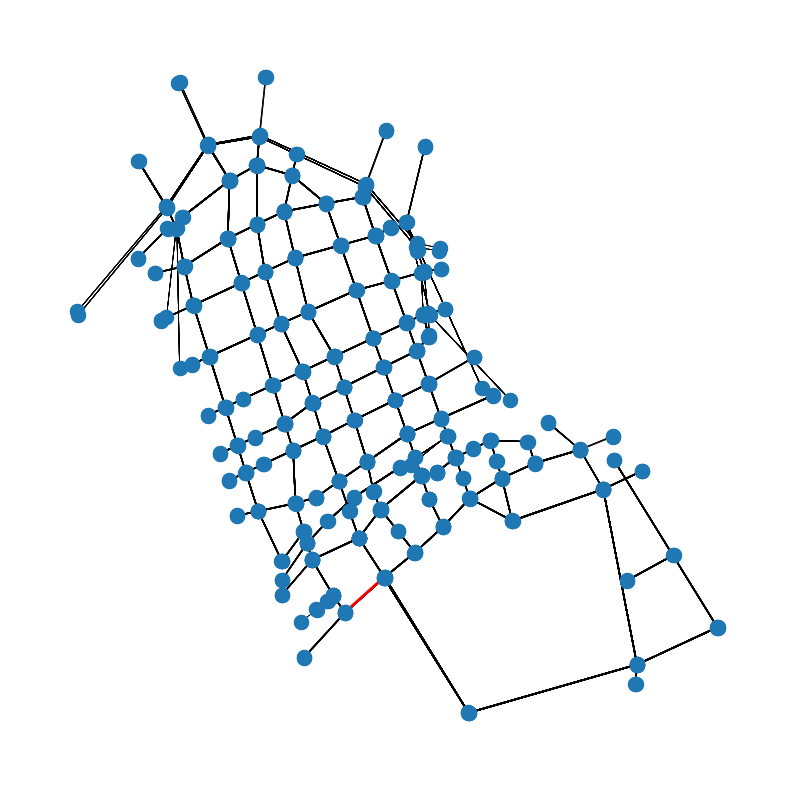

In [64]:
# draw network

fig, ax = plt.subplots(figsize=(10, 10))
import networkx as nx

nx.draw(network, pos={node: node for node in network.nodes()}, node_size=100, edge_color='black', width=0.5, ax=ax)

# first edge as red

# nx.draw(network, ax=ax, pos={node: node for node in network.nodes()}, node_size=100, edge_color='black', width=0.5)
edge = list(network.edges)[13]

nx.draw(network,pos={node: node for node in network.nodes()}, node_size=100, edgelist=[(edge[0],edge[1])], edge_color='red', width=2, ax=ax)

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_87666/1975901427.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


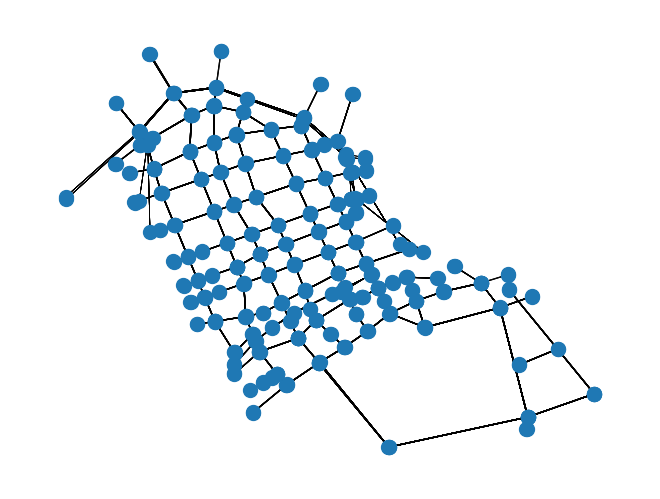

In [59]:
# new network removing edge
# network.remove_edge(*edge)

# draw network
nx.draw(network,pos={node: node for node in network.nodes()}, node_size=100, edge_color='black', width=0.5)

plt.tight_layout()
plt.show()

In [32]:
roads_selected.drop(columns=['ADM_SECT_C_left','SGG_OID_left','COL_ADM_SE_left'])

,geometry,SGG_NM_left,flood,office_cat_0,office_cat_1,office_cat_2,office_cat_3,office_cat_4,office_cat_5,office_cat_6,...,office_cat_9,elevation,rainpump,trees,road_area,trashcan,ADM_SECT_C_right,SGG_NM_right,SGG_OID_right,COL_ADM_SE_right
0,"POLYGON ((201121.000 447557.000, 201121.000 44...",서울특별시 용산구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,435.440110,0.0,825.113109,0.0,11680,서울특별시 강남구,1.0,11680
1,"POLYGON ((201121.000 447557.000, 201121.000 44...",서울특별시 서초구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,435.440110,0.0,825.113109,0.0,11680,서울특별시 강남구,1.0,11680
2,"POLYGON ((201121.000 447557.000, 201121.000 44...",서울특별시 강남구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,435.440110,0.0,825.113109,0.0,11680,서울특별시 강남구,1.0,11680
3,"POLYGON ((201121.000 447457.000, 201121.000 44...",서울특별시 용산구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,417.045402,0.0,0.000000,0.0,11680,서울특별시 강남구,1.0,11680
4,"POLYGON ((201121.000 447457.000, 201121.000 44...",서울특별시 서초구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,417.045402,0.0,0.000000,0.0,11680,서울특별시 강남구,1.0,11680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,"POLYGON ((210621.000 440757.000, 210621.000 44...",서울특별시 강남구,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.309999,163.599155,0.0,4646.124198,0.0,11680,서울특별시 강남구,1.0,11680
1444,"POLYGON ((210721.000 440957.000, 210721.000 44...",서울특별시 강남구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.390000,152.600866,0.0,48.807154,0.0,11680,서울특별시 강남구,1.0,11680
1445,"POLYGON ((210721.000 440957.000, 210721.000 44...",서울특별시 송파구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.390000,152.600866,0.0,48.807154,0.0,11680,서울특별시 강남구,1.0,11680
1446,"POLYGON ((210721.000 440857.000, 210721.000 44...",서울특별시 강남구,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,162.180113,0.0,0.000000,0.0,11680,서울특별시 강남구,1.0,11680


In [34]:
data_speed = pd.read_pickle('STGCN/data/pivoted_speed.pkl') # temp times node
data_flood = pd.read_pickle('STGCN/data/pivoted_flood.pkl') # temp times node

In [35]:
data_speed.head()

index,0,1,2,3,4,5,6,7,8,9,...,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-01 01:00:00,58.335,58.335,58.335,58.335,58.335,58.335,58.335,58.335,58.335,58.335,...,39.940,39.940,39.940,39.940,39.940,39.940,39.940,39.940,39.940,39.940
2022-06-01 02:00:00,59.835,59.835,59.835,59.835,59.835,59.835,59.835,59.835,59.835,59.835,...,41.465,41.465,41.465,41.465,41.465,41.465,41.465,41.465,41.465,41.465
2022-06-01 03:00:00,59.635,59.635,59.635,59.635,59.635,59.635,59.635,59.635,59.635,59.635,...,43.460,43.460,43.460,43.460,43.460,43.460,43.460,43.460,43.460,43.460
2022-06-01 04:00:00,58.975,58.975,58.975,58.975,58.975,58.975,58.975,58.975,58.975,58.975,...,41.875,41.875,41.875,41.875,41.875,41.875,41.875,41.875,41.875,41.875
2022-06-01 05:00:00,59.035,59.035,59.035,59.035,59.035,59.035,59.035,59.035,59.035,59.035,...,41.900,41.900,41.900,41.900,41.900,41.900,41.900,41.900,41.900,41.900
